Images loaded successfully.
i1 shape: (981, 736) dtype: uint8
i2 shape: (960, 656) dtype: uint8


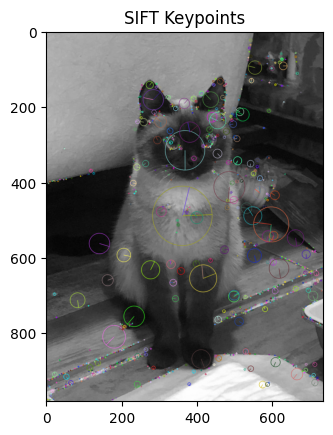

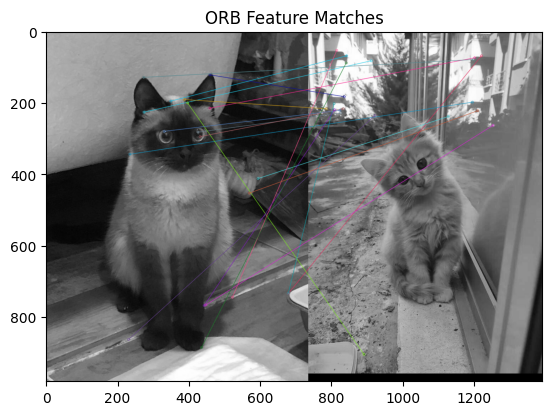

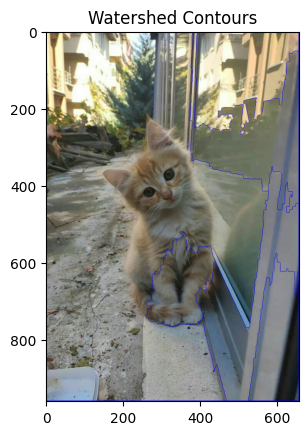

In [ ]:
# ---------------------- TASK 1 ----------------------
# Interest Point Detection using SIFT
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
# Check if the paths to your images are correct
i1 = cv2.imread('/content/Cat pic.jpeg', cv2.IMREAD_GRAYSCALE)
i2 = cv2.imread('/content/street baby cat.jpeg', cv2.IMREAD_GRAYSCALE)

# Check if images loaded correctly
if i1 is None or i2 is None:
    print("Error: Could not load images. Check file paths.")
    # If the above paths are incorrect, provide the full path to images
    # Example:
    # i1 = cv2.imread('/path/to/your/image1.jpg', cv2.IMREAD_GRAYSCALE)
    # i2 = cv2.imread('/path/to/your/image2.jpg', cv2.IMREAD_GRAYSCALE)
else:
    print("Images loaded successfully.")
    print("i1 shape:", i1.shape, "dtype:", i1.dtype)
    print("i2 shape:", i2.shape, "dtype:", i2.dtype)

# SIFT Detector
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(i1, None)
kp2, des2 = sift.detectAndCompute(i2, None)

# Draw keypoints
img_sift = cv2.drawKeypoints(i1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_sift, cmap='gray')
plt.title("SIFT Keypoints")
plt.show()

# ORB + BFMatcher for Feature Matching
orb = cv2.ORB_create()
kp1_orb, des1_orb = orb.detectAndCompute(i1, None)
kp2_orb, des2_orb = orb.detectAndCompute(i2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1_orb, des2_orb)
matches = sorted(matches, key=lambda x: x.distance)

img_matches = cv2.drawMatches(i1, kp1_orb, i2, kp2_orb, matches[:20], None, flags=2)
plt.imshow(img_matches)
plt.title("ORB Feature Matches")
plt.show()

# Contour Detection with Watershed
img = cv2.imread('/content/street baby cat.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Apply watershed
markers = cv2.watershed(img, markers)
img[markers == -1] = [255, 0, 0]

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Watershed Contours")
plt.show()

In [ ]:
# Image Restoration using Autoencoder (on MNIST)
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Add Gaussian Noise
def add_noise(imgs):
    noise = np.random.normal(loc=0.0, scale=0.5, size=imgs.shape)
    noisy_imgs = imgs + noise
    noisy_imgs = np.clip(noisy_imgs, 0., 1.)
    return noisy_imgs

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

# Autoencoder Model
input_img = tf.keras.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train
autoencoder.fit(x_train_noisy, x_train, epochs=10, batch_size=128, shuffle=True, validation_data=(x_test_noisy, x_test))

# Predict and Evaluate
preds = autoencoder.predict(x_test_noisy)

from skimage.metrics import peak_signal_noise_ratio as psnr
print("PSNR:", np.mean([psnr(x_test[i], preds[i]) for i in range(100)]))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 112s 233ms/step - loss: 0.1236 - val_loss: 0.1140
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 134s 215ms/step - loss: 0.1117 - val_loss: 0.1140
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 213ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 144s 217ms/step - loss: 0.1122 - val_loss: 0.1140
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 219ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 219ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 217ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 214ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 217ms/step - loss: 0.1117 - val_loss: 0.1140
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 216ms/step - loss: 0.1118 - val_loss: 0.1140
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
PSNR: 